# (size abundance slope)at 100m and at the surface 
* log(abs) vs log(volume) annually

**** new approach ****

Before this, I would exclude the diazotrophs from this trend becuase they are not found in the Arctic, so they show up as a nan value that creates the whole regression a nan for the Arctic. By taking them out, we solve that problem completely, but that affected the slope of regions that did not have diazotrophs, and any other group that was not found in any other region.. 

SO.... I think I finally figured it out. I instead of making them into nan's I made them into Zeros, and instead of taking just the regular log10, I added a 1 to all of the values so if there are values that are zero's they do not affect the slopes and they just become zeros after the log. 

This solved the problem of having ot have a mask for the diazotrophs, and the slopes look a lot more like they should be looking. 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib as mpl
import os
import matplotlib.gridspec as gridspec

In [3]:
stats.linregress?

Signature: stats.linregress(x, y=None)
Docstring:
Calculate a linear least-squares regression for two sets of measurements.

Parameters
----------
x, y : array_like
    Two sets of measurements.  Both arrays should have the same length.  If
    only `x` is given (and ``y=None``), then it must be a two-dimensional
    array where one dimension has length 2.  The two sets of measurements
    are then found by splitting the array along the length-2 dimension.  In
    the case where ``y=None`` and `x` is a 2x2 array, ``linregress(x)`` is
    equivalent to ``linregress(x[0], x[1])``.

Returns
-------
slope : float
    Slope of the regression line.
intercept : float
    Intercept of the regression line.
rvalue : float
    Correlation coefficient.
pvalue : float
    Two-sided p-value for a hypothesis test whose null hypothesis is
    that the slope is zero, using Wald Test with t-distribution of
    the test statistic.
stderr : float
    Standard error of the estimated gradient.

See also
---

In [19]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [20]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## input file

In [21]:
## print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

 GNG595


What year? (year)


 20yrclim


In [22]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [23]:
### last 20 year climatology of the second cycle representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

In [24]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Import the abundance  and volume of the community 
* Units for pytoplankton: 
    * $volume$ [$um^3$]
* Units for zooplankton 
    * $volume$ [$m^3$] converted to [$um^3$] by multiplying by [$10^9$]

In [25]:
## Gaby's Path 
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+new_file+'/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mass_ugC') # sorting sizes by mass in ugC 
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


### we want to compare the slopes from log mean population abundance in cells/mL^{-1} to lof od cell volume in (um^3) to be consistent with cermeno et al. 2006

In [26]:
# Sorting mass and names of only the phytoplankton by mass. 
phyto_mass = array([sizes.mass_ugC[1],sizes.mass_ugC[2],sizes.mass_ugC[0],sizes.mass_ugC[3],
                   sizes.mass_ugC[6],sizes.mass_ugC[7],sizes.mass_ugC[4],sizes.mass_ugC[8],
                   sizes.mass_ugC[5]]) # ugC 

phyto_vol = array([sizes.vol_um3[1],sizes.vol_um3[2],sizes.vol_um3[0],sizes.vol_um3[3],
                   sizes.vol_um3[6],sizes.vol_um3[7],sizes.vol_um3[4],sizes.vol_um3[8],
                   sizes.vol_um3[5]]) # units of um^3 (this is good). 

phyto_names = array([sizes.sname[1],sizes.sname[2],sizes.sname[0],sizes.sname[3],
                   sizes.sname[6],sizes.sname[7],sizes.sname[4],sizes.sname[8],
                   sizes.sname[5]])

In [27]:
# Using that same order of size for phytoplankton to calculate the biomass in that same order. 
phyto_vars = [v+'C' for v in phyto_names] # mmol C /m^3
phyto_bmss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol C m-3
phyto_bmss = phyto_bmss.sum(dim='z_t_150m') * 10/150 #integrate over depth #mmol m-3
phyto_bmss = phyto_bmss * 12.011 *1000 # ug C m-3

## Abundance 

In [28]:
# calcualte the abundance of each phytoplankton with biomass and mass in the same order. 
phyto_abu = np.zeros((9,12,384,320))
for i in range(9):
    phyto_abu[i,:,:,:] = phyto_bmss[i,:,:,:]/phyto_mass[i] # ug C cm^{-3} / ug C -->  cell/ m^3 

In [29]:
# log of volumes for phytoplankton, zooplankton and both. 
xp = np.log10(phyto_vol+1)

# Make any abundances that are less than zero into zeros. 
phyto_abu[phyto_abu<0] = 0

# abundance for phyto for the top 150m. (since there are zeros, add 1 to calculate the log10). 
phyto_abu = np.log10(phyto_abu[:,:,:,:]+1)

# the size of 1,474,560
n = 12*384*320

# reshape the 4-D array to a 2-D array. 
yp_reshape = phyto_abu.reshape((9, n))

# create the calculation 
yp_results = np.empty((n, 5))

for i in range(n):
    yp_results[i] = stats.linregress(xp, yp_reshape[:,i])
    
# reshape back to size wanted. back to 4D, but the 5 is where the slope, interecpt, etc. are. 
ypp_surface = yp_results.reshape((12,384,320, 5)) 

In [30]:
# any slopes that are equal to zeros, make them into nan values. 
ypp_surface[ypp_surface==0]=np.nan

## Winter, Spring, Summer and Fall. 

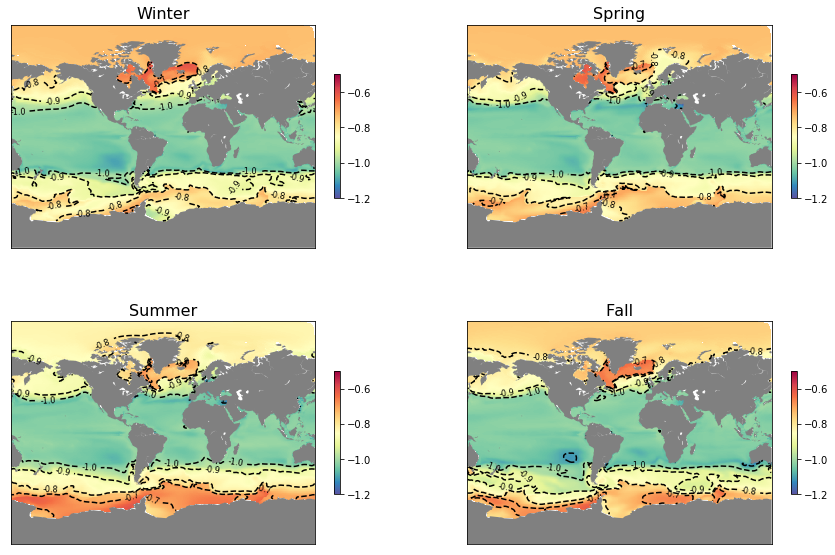

In [41]:
fig = plt.figure(figsize=(15, 10))
lat = ds.TLAT[:,1]

## WINTER 
ax = fig.add_subplot(2, 2, 1)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[list(range(2)) + [-1],:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -1.2, vmax = -0.5)
cs = m.contour(x, y, winter,levels = [-1.2,-1.1,-1,-0.9, -0.8, -0.7,-0.6,-0.5],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Winter', fontsize =16)

## SPRING
ax = fig.add_subplot(2, 2, 2)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[2:5,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = -1.2, vmax = -0.5)
cs = m.contour(x, y, spring,levels = [-1.2,-1.1,-1,-0.9, -0.8, -0.7,-0.6,-0.5],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Spring', fontsize =16)

## SUMMER
ax = fig.add_subplot(2, 2, 3)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[5:8,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = -1.2, vmax = -0.5)
cs = m.contour(x, y, summer,levels = [-1.2,-1.1,-1,-0.9, -0.8, -0.7,-0.6,-0.5],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Summer', fontsize =16)


##FALL
ax = fig.add_subplot(2, 2, 4)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[8:11,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,fall,cmap='Spectral_r', vmin = -1.2, vmax = -0.5)
cs = m.contour(x, y, fall,levels = [-1.2,-1.1,-1,-0.9, -0.8, -0.7,-0.6,-0.5],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Fall', fontsize =16);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SSS_surf_seasonal_global_'+year+'year.png', dpi=600, bbox_inches='tight')

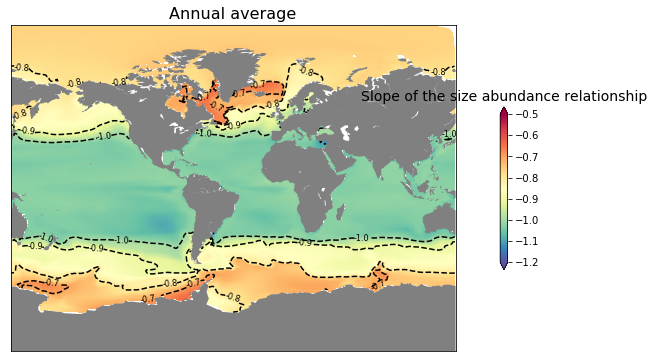

In [42]:
# this creates all zero slopes into a nan. 
ypp_surface[ypp_surface==0]=np.nan

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[:,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,phyto,cmap='Spectral_r', vmin = -1.2, vmax = -0.5)
cs = m.contour(x, y, phyto,levels = [-1.2,-1.1,-1,-0.9, -0.8,-0.7, -0.6, -0.5],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, extend ='both')
cb.ax.set_title('Slope of the size abundance relationship', fontsize=14)
ax.set_title('Annual average', fontsize = 16);

# save the figure 
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SSS_surf_annual_'+year+'year.png', dpi=600, bbox_inches='tight')

import scipy.io as sio
sio.savemat('size_spectral_slope_surface.mat',{'phyto_regression_surface':ypp_surface, 
                                               'phyto_regression_100m':ypp_100m})

In [43]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [52]:
lev = np.arange(-1.1, -0.495, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-0.8)
ypp_surface[ypp_surface==0]=np.nan

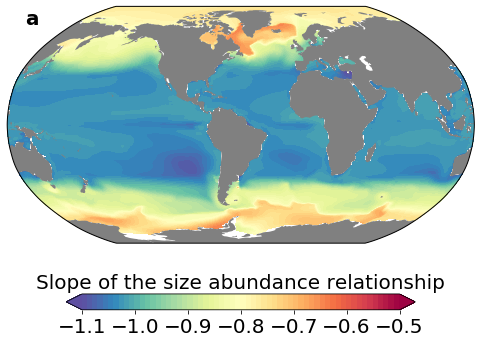

In [53]:
fig = plt.figure(figsize=(10, 5))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[:,:,:,0].mean(axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, phyto, vmin=-1.1, vmax=-0.5,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
#cs = ax.contour(x, y, phyto, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
#lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1.1,-1,-0.9, -0.8,-0.7, -0.6,-0.5],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Slope of the size abundance relationship', fontsize=20)
fig.text(0.20, 0.92, 'a',fontsize=20, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SSS_surf_annual_'+year+'year.png', dpi=600, bbox_inches='tight')

In [54]:
biome_mask = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124.nc')

region_names = ['Eq-D','Eq-U','S-ST-PS','N-ST-PS','S-ST-SS','N-ST-SS','S-LL-U','N-LL-U','S-SP-SS','N-SP-SS','S-SIZ','N-SIZ']
region_NtoS_index = [11,9,5,3,7,1,0,6,2,4,8,10]
region_NtoS_names = [region_names[i] for i in region_NtoS_index]

In [55]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [56]:
nbiome = len(biome_mask.region.values)
nt = len(ds.time.values)

In [57]:
index = pd.Index(region_NtoS_names, name='region')
nbiome = len(region_NtoS_names)
biome_means = np.zeros(shape=(nt,nbiome,1))

photoC_data={}
for i in range(nbiome):
    r = region_NtoS_index[i]
    name = region_NtoS_names[i]
    region = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=r).values == 1)

    for t in range(nt):
        tmp_obs = ypp_surface[t,:,:,0][region]
        biome_means[t,i,0] = np.nanmean(tmp_obs)

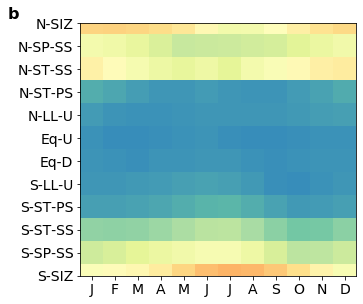

In [58]:
# bias plot
fig = plt.figure(figsize=(5,5))

fig.text(0.0, 0.88, 'b',fontsize=16, fontweight='bold')


ax = fig.add_subplot(1, 1, 1)
biome_diffs = biome_means[:,:,0]
plt.imshow(biome_diffs.T, vmin=-1.1, vmax=-0.5, cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 14 );plt.yticks(fontsize= 14 );


fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SSS_biome'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')